In [4]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from tensorflow.math import confusion_matrix
import seaborn as sns
from sklearn import metrics
from WorkingPaper.python_model_antoine_ML.DL_logic.cleaning import final_cleaning
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from pdfminer.high_level import extract_text
from WorkingPaper.save_load_models.save_model import save_model

In [5]:
data = pd.read_csv('../../raw_data/data_9k.csv')
data.head()

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,id,title,text,topic,subtopic
0,0,0.0,0.0,https://openalex.org/W2100716186,Large-scale screening of hypothetical metal-or...,PUBLISHED ONLINE: 6 NOVEMBER 2011 | DOI: 10.10...,Chemistry,Nanotechnology
1,1,1.0,1.0,https://openalex.org/W2109370530,Routing and wavelength assignment in all-optic...,"[H+./ACM TRANSACTIONS ON NETWORKING, VO1. 3, N...",Computer science,Telecommunications
2,2,2.0,2.0,https://openalex.org/W2131625303,Potassium channel antibody-associated encephal...,"DOI: 10.1093/brain/awh077 Brain (2004), 127, ...",Medicine,Pediatrics
3,3,3.0,3.0,https://openalex.org/W2131736388,"MODBASE, a database of annotated comparative p...","D336–D346 Nucleic Acids Research, 2014, Vol. 4...",Computer science,Bioinformatics
4,4,4.0,4.0,https://openalex.org/W2144966005,Regional brain volume abnormalities and long-t...,ORIGINAL CONTRIBUTION Regional Brain Volume A...,Medicine,Internal medicine


In [6]:
# Reading data 2
data_2 = pd.read_csv('../../raw_data/preprocessed_data.csv')
data_2.head()

,id,title,text,topic,subtopic,total words per text,modified text,words per modified text,broader_subtopic
0,https://openalex.org/w1968762427,rapid amplification of plasmid and phage dna u...,downloaded from genome cshlp org on septem...,biology,molecular biology,23397,"['download', 'genome', 'cshlp', 'org', 'septem...",2303,genetics and molecular biology
1,https://openalex.org/w2099571549,microbial communities in acid mine drainage,abstract the dissolution of sulfide minerals ...,biology,ecology,71203,"['abstract', 'dissolution', 'sulfide', 'minera...",2965,ecology
2,https://openalex.org/w2123562143,polynomial time algorithms for multicast netwo...,abstract the famous max ow min cut theorem st...,mathematics,combinatorics,45200,"['abstract', 'famous', 'max', 'ow', 'min', 'cu...",2774,NaN
3,https://openalex.org/w2149244682,combination immunotherapy of b16 melanoma usin...,combination immunotherapy of b melanoma usin...,biology,cancer research,63844,"['combination', 'immunotherapy', 'melanoma', '...",2884,genetics and molecular biology
4,https://openalex.org/w2536956629,situating the default-mode network along a pri...,abstract background psp is a neuropathologica...,psychology,neuroscience,59152,"['abstract', 'background', 'psp', 'neuropathol...",2901,NaN


In [7]:
print(data['topic'].value_counts())
print(data_2['topic'].value_counts())

Biology                  3138
Medicine                 2064
Chemistry                 834
Psychology                657
Computer science          635
Physics                   321
Materials science         314
Mathematics               244
Environmental science     222
Economics                 176
Business                  109
Geology                    93
Geography                  84
Sociology                  48
Political science          37
Engineering                24
History                     6
Art                         4
Philosophy                  3
Name: topic, dtype: int64
mathematics    918
physics        630
biology        129
psychology      52
Name: topic, dtype: int64


In [8]:
data_math = data_2.loc[data_2['topic'] == 'mathematics']
data_phy = data_2.loc[data_2['topic'] == 'physics']
data_biology = data.loc[data['topic'] == 'Biology'][:500]
data_medecine = data.loc[data['topic'] == 'Medicine'][:500]
data_life_science = pd.concat([data_biology,data_medecine])
data_life_science['topic'] = 'life_science'
#data_chemistry = data.loc[data['topic'] == 'Chemistry']
data_life_science['topic'].value_counts()
#frames = [data_biology[['text','topic']],data_medecine[['text','topic']]]
#result = pd.concat(frames)

life_science    1000
Name: topic, dtype: int64

In [9]:
data_life_science['text'] = data_life_science['text'].apply(lambda x: final_cleaning(str(x)))

In [10]:
final_data = pd.concat([data_life_science[['text','topic']],data_math[['text','topic']],data_phy[['text','topic']]])

In [11]:
final_data.shape

(2548, 2)

In [12]:
data = final_data
data = data.dropna()

In [13]:
data['text'] = data['text'].apply(lambda x : ' '.join(x.split()[0:1000]))

In [14]:
data.head()

,text,topic
5,intact opensource open data molecular inter ac...,life_science
9,ded genomecshlporg september publish cold spri...,life_science
11,rnal neuroscience august behavioralsystemscogn...,life_science
15,crobiology ecology wwwfemsmicrobiologyorg mini...,life_science
20,tion immunotherapy melanoma use anti cytotoxic...,life_science


In [15]:
# OneHot Encoding topics
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
topic_targets_enc = pd.DataFrame(enc.fit_transform(data[['topic']]))
topic_targets_enc.columns = enc.get_feature_names_out()

In [16]:
topic_targets_enc.columns

Index(['topic_life_science', 'topic_mathematics', 'topic_physics'], dtype='object')

In [17]:
data[['topic']].value_counts()

topic       
life_science    1000
mathematics      918
physics          630
dtype: int64

In [18]:
data.isnull().sum()

text     0
topic    0
dtype: int64

In [19]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(data['text'], topic_targets_enc, test_size=0.3)

In [20]:
# N-gram 
count_vectorizer_n_gram = CountVectorizer(ngram_range = (2,2),min_df = 3,max_df=50)
count_vectorized_train = count_vectorizer_n_gram.fit_transform(X_train)
count_vectorized_test = count_vectorizer_n_gram.transform(X_test)

In [21]:
count_vectorized_train.toarray().shape

(1783, 97288)

In [22]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(count_vectorized_train,np.argmax(np.array(y_train), axis=1))
# predict the labels on validation dataset
predictions_SVM = SVM.predict(count_vectorized_test)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, np.argmax(np.array(y_test), axis=1))*100)

SVM Accuracy Score ->  92.81045751633987


Confusion matrix:
[[296   0   0]
 [  3 247  25]
 [  4  23 167]]
0 topic_life_science
1 topic_mathematics
2 topic_physics


2022-09-08 12:52:11.222480: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


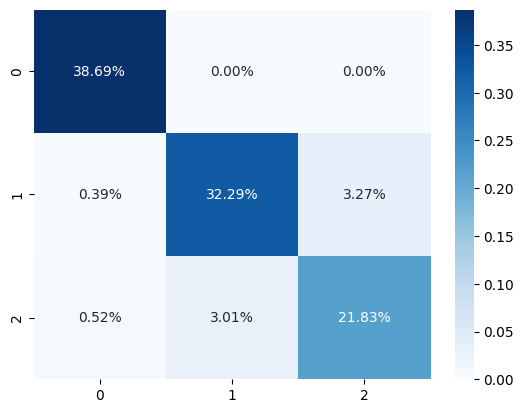

In [23]:
print("Confusion matrix:")
print(metrics.confusion_matrix(np.argmax(np.array(y_test), axis=1), predictions_SVM))

conf_matrix = confusion_matrix(labels=np.argmax(np.array(y_test), axis=1), predictions=predictions_SVM)
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues')
for i, column in enumerate(topic_targets_enc.columns):
    print(i, column)

In [ ]:
preprocessor = CountVectorizer()
classifier_SVM = svm.SVC(gamma='auto')


pipeline = Pipeline(steps=[("preprocesser", preprocessor), ("classifier_SVM", classifier_SVM)])
pipeline

Pipeline(steps=[('preprocesser', CountVectorizer()),
                ('classifier_SVM', SVC(gamma='auto'))])

In [ ]:
param_grid = [
    {
        "preprocesser__ngram_range": [(2,2),(1,3)],
        "preprocesser__max_features": [30000,250000],
        "preprocesser__max_df": [20,50,100],
        "classifier_SVM__C": [0.1, 1.0, 10.0],
        "classifier_SVM__kernel": ['linear'],
        
    }
]

In [3]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1,n_jobs=-1)

NameError: name 'GridSearchCV' is not defined

In [66]:
grid_search.fit(X_train, np.argmax(np.array(y_train), axis=1))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/antoinelemaire/.pyenv/versions/3.8.12/envs/WorkingPaper/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesser', CountVectorizer()),
                                       ('classifier_SVM', SVC(gamma='auto'))]),
             n_jobs=-1,
             param_grid=[{'classifier_SVM__C': [0.1, 1.0, 10.0],
                          'classifier_SVM__kernel': ['linear'],
                          'preprocesser__max_df': [20, 50, 100],
                          'preprocesser__max_features': [30000, 250000],
                          'preprocesser__ngram_range': [(2, 2), (1, 3)]}],
             verbose=1)

In [67]:
grid_search.best_params_

{'classifier_SVM__C': 0.1,
 'classifier_SVM__kernel': 'linear',
 'preprocesser__max_df': 100,
 'preprocesser__max_features': 30000,
 'preprocesser__ngram_range': (2, 2)}

In [68]:
grid_search.best_score_


0.5392829625221184

# Final pipeline

In [24]:
preprocessor = CountVectorizer(max_df=100,max_features=30000,ngram_range=(2,2))
classifier_SVM = svm.SVC(gamma='auto', C=0.1, kernel='linear')


pipeline_1 = Pipeline(steps=[("preprocesser", preprocessor), ("classifier_SVM", classifier_SVM)])
pipeline_1

Pipeline(steps=[('preprocesser',
                 CountVectorizer(max_df=100, max_features=30000,
                                 ngram_range=(2, 2))),
                ('classifier_SVM', SVC(C=0.1, gamma='auto', kernel='linear'))])

In [25]:
pipeline_1.fit(X_train, np.argmax(np.array(y_train), axis=1))

Pipeline(steps=[('preprocesser',
                 CountVectorizer(max_df=100, max_features=30000,
                                 ngram_range=(2, 2))),
                ('classifier_SVM', SVC(C=0.1, gamma='auto', kernel='linear'))])

In [26]:
pipeline_1.score

<bound method Pipeline.score of Pipeline(steps=[('preprocesser',
                 CountVectorizer(max_df=100, max_features=30000,
                                 ngram_range=(2, 2))),
                ('classifier_SVM', SVC(C=0.1, gamma='auto', kernel='linear'))])>

In [27]:
prediction_pipe = pipeline_1.predict(X_test)

In [28]:
accuracy_score(prediction_pipe, np.argmax(np.array(y_test), axis=1))

0.9333333333333333

Confusion matrix:
[[296   0   0]
 [  2 249  24]
 [  4  21 169]]
0 topic_life_science
1 topic_mathematics
2 topic_physics


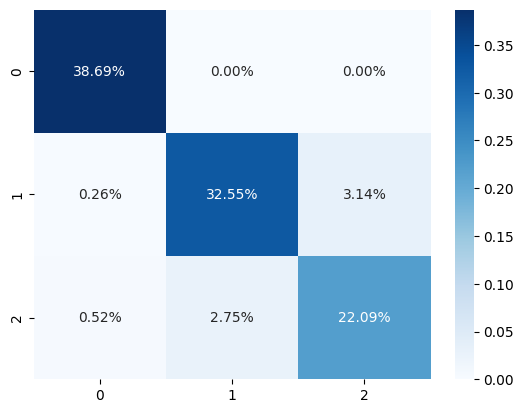

In [29]:
print("Confusion matrix:")
print(metrics.confusion_matrix(np.argmax(np.array(y_test), axis=1), prediction_pipe))

conf_matrix = confusion_matrix(labels=np.argmax(np.array(y_test), axis=1), predictions=prediction_pipe)
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues')
for i, column in enumerate(topic_targets_enc.columns):
    print(i, column)

# multiple model

# saving the model

In [67]:
from tensorflow.keras import models
import joblib

def save_model_2(model = None):
    #model.save('WorkingPaper/local/ML_model_layer1.h5')
    path = '../local/ML_model_layer1.pkl'
    joblib.dump(model, path)
    return None

In [68]:
save_model_2(model = pipeline_1)

# try with 1 pdf

In [34]:
v1 = extract_text('/Users/antoinelemaire/code/Fito-22/WorkingPaper/raw_data/biology_2.pdf')
v2 = extract_text('/Users/antoinelemaire/code/Fito-22/WorkingPaper/raw_data/Biology_3.pdf')
v3 = extract_text('/Users/antoinelemaire/code/Fito-22/WorkingPaper/raw_data/biology.pdf')
v4 = extract_text('/Users/antoinelemaire/code/Fito-22/WorkingPaper/raw_data/math.pdf')
v5 = extract_text('/Users/antoinelemaire/code/Fito-22/WorkingPaper/raw_data/physics.pdf')
v6 = extract_text('/Users/antoinelemaire/code/Fito-22/WorkingPaper/raw_data/physics_2.pdf')
v7 = extract_text('/Users/antoinelemaire/code/Fito-22/WorkingPaper/raw_data/medicine.pdf')
v8 = extract_text('/Users/antoinelemaire/code/Fito-22/WorkingPaper/raw_data/medicine_2.pdf')

In [88]:
text = final_cleaning(v8)

In [69]:
pipeline_loaded = joblib.load('../../WorkingPaper/local/ML_model_layer1.joblib')

In [89]:
text_to_pred = np.array([text])

In [90]:
y_pred = pipeline_loaded.predict(text_to_pred)

In [95]:
print(y_pred[0]==0)

True
